In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [4]:
image_path = '/content/drive/MyDrive/polyp images/Original'
mask_path = '/content/drive/MyDrive/polyp images/Ground Truth'

In [5]:
IMG_HEIGHT, IMG_WIDTH = 256, 256

def load_images(img_folder, mask_folder, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    images = []
    masks = []

    img_files = sorted(os.listdir(img_folder))
    mask_files = sorted(os.listdir(mask_folder))

    for img_file, mask_file in zip(img_files, mask_files):
        # Load image
        img = load_img(os.path.join(img_folder, img_file), target_size=img_size)
        img = img_to_array(img) / 255.0
        images.append(img)

        # Load mask
        mask = load_img(os.path.join(mask_folder, mask_file), target_size=img_size, color_mode='grayscale')
        mask = img_to_array(mask) / 255.0
        masks.append(mask)

    return np.array(images), np.array(masks)

images, masks = load_images(image_path, mask_path)
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (612, 256, 256, 3)
Masks shape: (612, 256, 256, 1)


In [6]:
import numpy as np

# Save arrays
np.save("images.npy", images)
np.save("masks.npy", masks)


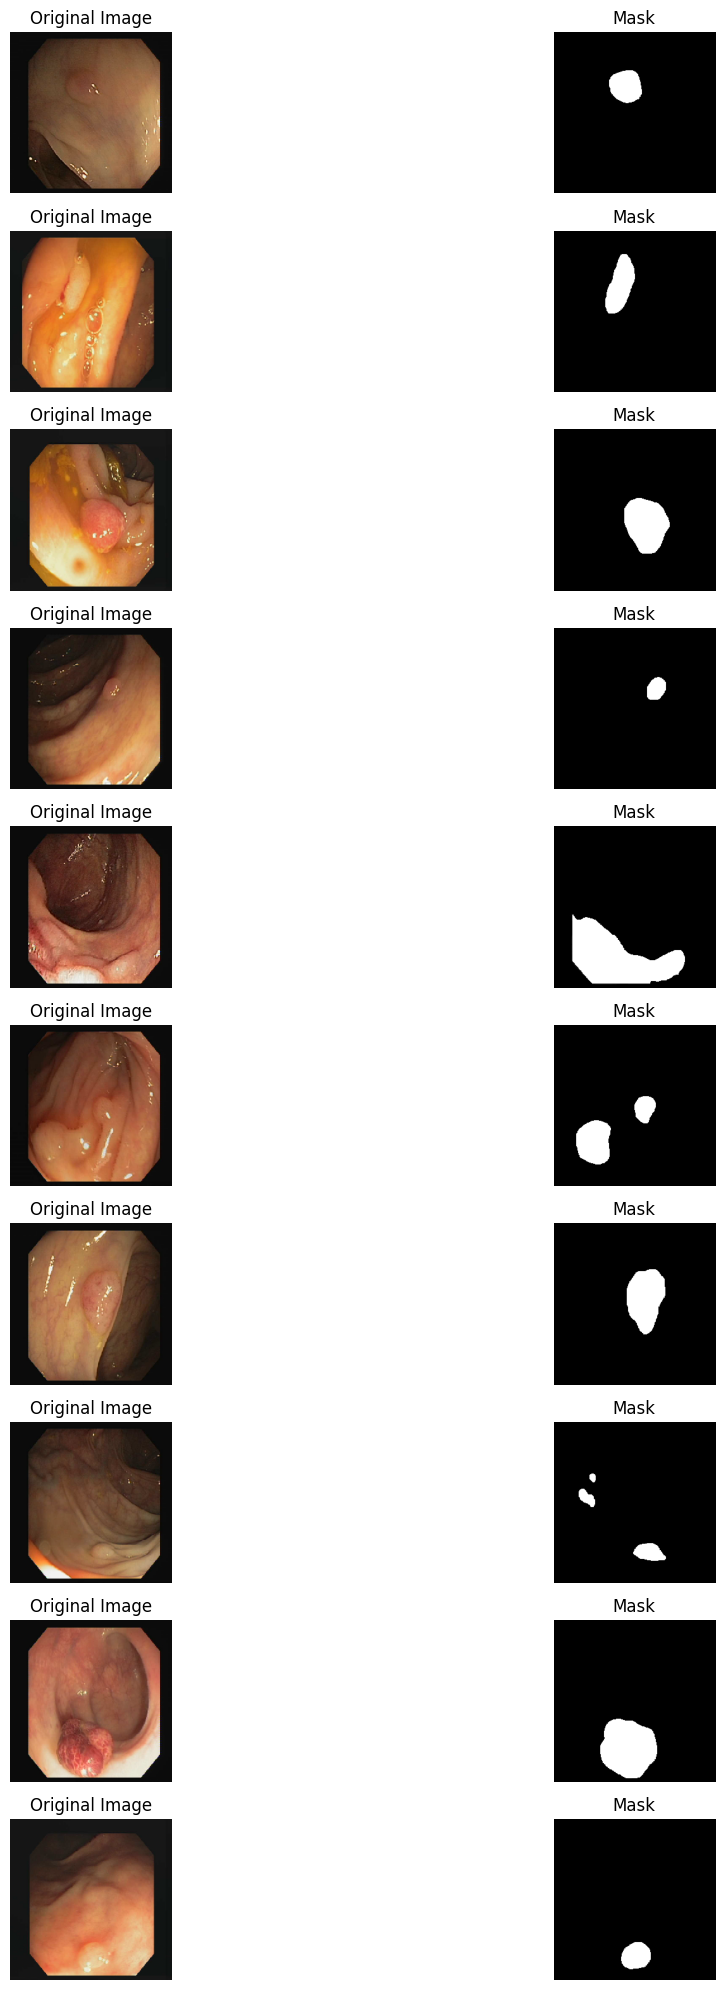

In [7]:
def visualize_dataset(images, masks, n=10):
    idx = random.sample(range(len(images)), n)
    plt.figure(figsize=(15, n * 2))
    for i, j in enumerate(idx):
        # Original image
        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(images[j])
        plt.title("Original Image")
        plt.axis('off')

        # mask
        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(masks[j].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_dataset(images, masks, n=10)

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(images, masks, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

print("Training:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Training: (495, 256, 256, 3) (495, 256, 256, 1)
Validation: (55, 256, 256, 3) (55, 256, 256, 1)
Test: (62, 256, 256, 3) (62, 256, 256, 1)


In [9]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
EPOCHS = 20
BATCH_SIZE = 8

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.9010 - loss: 0.9157 - val_accuracy: 0.9187 - val_loss: 0.2463
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 65s 451ms/step - accuracy: 0.9125 - loss: 0.2525 - val_accuracy: 0.9187 - val_loss: 0.2219
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 450ms/step - accuracy: 0.9038 - loss: 0.2468 - val_accuracy: 0.9187 - val_loss: 0.2333
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 449ms/step - accuracy: 0.9094 - loss: 0.2351 - val_accuracy: 0.9183 - val_loss: 0.2218
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 452ms/step - accuracy: 0.9094 - loss: 0.2308 - val_accuracy: 0.9084 - val_loss: 0.2349
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - accuracy: 0.9119 - loss: 0.2320 - val_accuracy: 0.9194 - val_loss: 0.2218
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 450ms/step - accuracy: 0.9155 - loss: 0.2344 - val_accuracy: 0.9168 - val_loss: 0.2174
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 446ms/step - accuracy: 0.9125 - loss: 0.2264 - val_accura

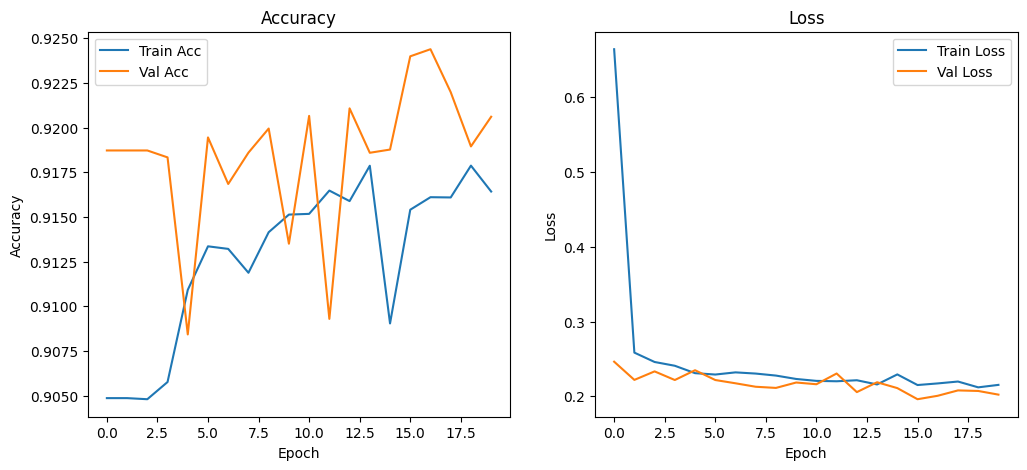

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 87s 43s/step - accuracy: 0.9177 - loss: 0.2058
Test Loss: 0.2033, Test Accuracy: 0.9198


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


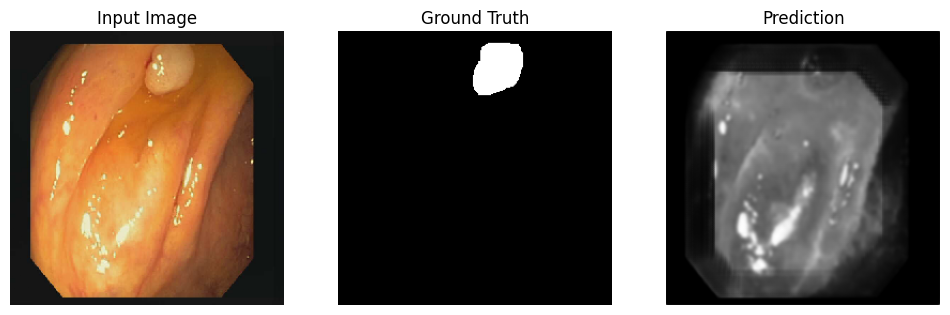

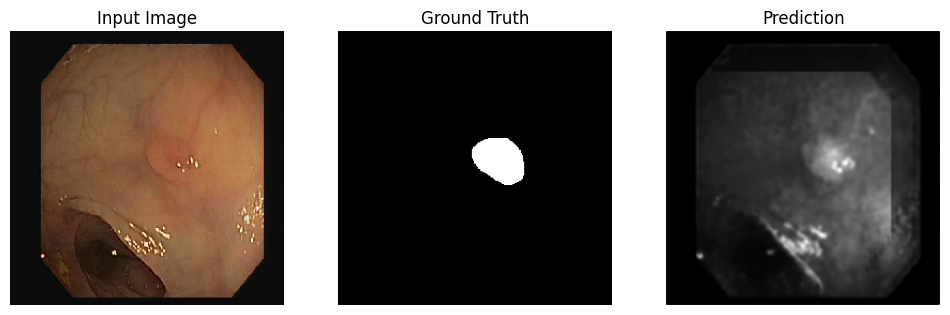

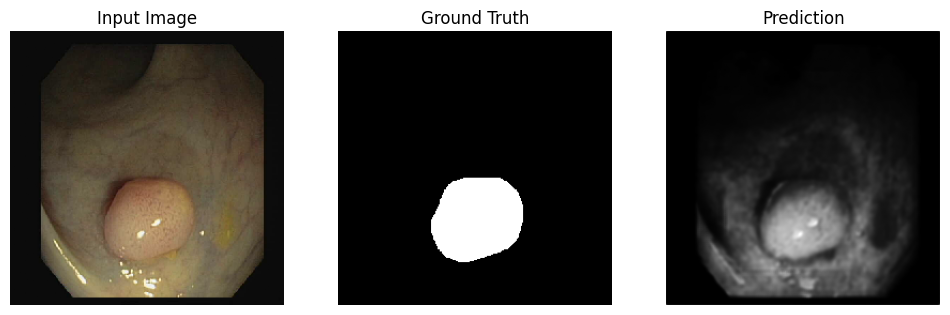

In [13]:
# Visualize predictions
def visualize_prediction(model, X, y, n=3):
    preds = model.predict(X[:n])
    for i in range(n):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(X[i])
        plt.title('Input Image')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
        plt.show()

visualize_prediction(model, X_test, y_test)